<a id=top-page></a>
# Cost function application to t-SNE hyper-parameter tuning

In this notebook, we explore the application of the cost function, $\mathcal{L}$, to hyper-parameter tuning in t-SNE.

The analysis in this notebook is performed in the following steps:

- [Generate 3D toy data](#3D-data)
    - [Test perplexity](#3D-data-perplexity)
- [Generate 2D toy data](#2D-data)
    - [Test perplexity](#2D-data-perplexity)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
bandwidth_values = np.logspace(-7, 3, 200)
penalty = 'log-sigma-over-peak'
norm = 'max'
power = 1
colormap = 'plasma'
save_figures = True

<a id=3D-data></a>
***

## Generate 3D toy data

[Go to the top](#top-page)

In [3]:
n_points = 100

x, y = np.meshgrid(np.linspace(-1,1,n_points), np.linspace(-1,1,n_points))
x = x.ravel()[:,None]
y = y.ravel()[:,None]

std=0.4

z = np.exp(-((x*x+y*y) / (2.0 * std**2))) * np.sin(10*x*y)
z = z.ravel()[:,None]
z = z/np.max(z)

depvar = np.exp(-((x*x+y*y) / (2.0 * 0.8**2)))
depvar = depvar.ravel()[:,None]
depvar = depvar/np.max(depvar)

data = np.hstack((x,y,z))

idx = np.array([i for i in range(0,len(x))]).ravel()[:,None]

(n_observations, _) = np.shape(data)

In [4]:
tic = time.perf_counter()

variance_data = analysis.compute_normalized_variance(data,
                                                     depvar,
                                                     depvar_names=['var'],
                                                     bandwidth_values=bandwidth_values)

derivative, sigmas, _ = analysis.normalized_variance_derivative(variance_data)

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 1.0 minutes.
----------------------------------------


In [5]:
cost = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                             penalty_function=penalty,
                                                             power=power,
                                                             norm=norm,
                                                             integrate_to_peak=False)

print(cost)

0.7868591163716205


<a id=3D-data-perplexity></a>
### Test perplexity

[Go to the top](#top-page)

In [6]:
X_TSNE_1 = manifold.TSNE(n_components=2, perplexity=1, init="pca", random_state=random_seed).fit_transform(data)
X_TSNE_30 = manifold.TSNE(n_components=2, perplexity=30, init="pca", random_state=random_seed).fit_transform(data)

In [7]:
tic = time.perf_counter()

variance_data_1 = analysis.compute_normalized_variance(X_TSNE_1,
                                                       depvar,
                                                       depvar_names=['var'],
                                                       bandwidth_values=bandwidth_values)

derivative_1, sigmas_1, _ = analysis.normalized_variance_derivative(variance_data_1)

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.9 minutes.
----------------------------------------


In [8]:
cost_perplexity_1 = analysis.cost_function_normalized_variance_derivative(variance_data_1,
                                                                          penalty_function=penalty,
                                                                          power=power,
                                                                          norm=norm,
                                                                          integrate_to_peak=False)

print(cost_perplexity_1)

1.2792453461647981


In [9]:
tic = time.perf_counter()

variance_data_30 = analysis.compute_normalized_variance(X_TSNE_30,
                                                        depvar,
                                                        depvar_names=['var'],
                                                        bandwidth_values=bandwidth_values)

derivative_30, sigmas_30, _ = analysis.normalized_variance_derivative(variance_data_30)

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 1.0 minutes.
----------------------------------------


In [10]:
cost_perplexity_30 = analysis.cost_function_normalized_variance_derivative(variance_data_30,
                                                                           penalty_function=penalty,
                                                                           power=power,
                                                                           norm=norm,
                                                                           integrate_to_peak=False)

print(cost_perplexity_30)

0.907116351738704


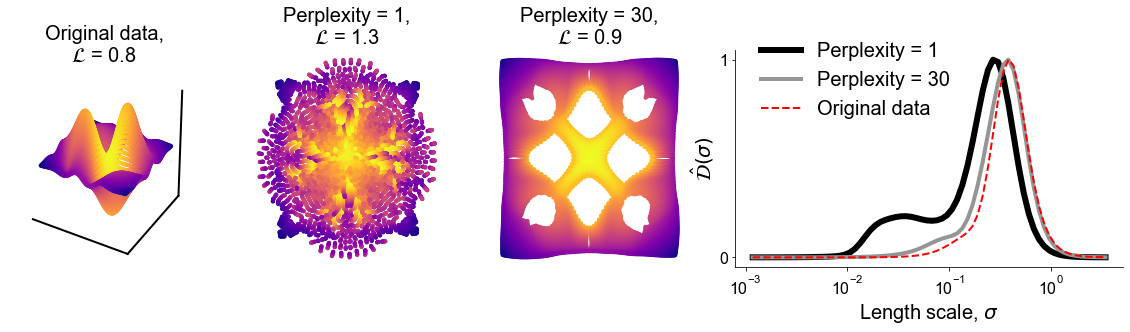

In [13]:
fig = plt.figure(figsize=(20, 4))
widths = [1, 1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=widths, height_ratios=heights)

color_map_colors = cm.get_cmap('Greys')
colors = np.flipud(color_map_colors(np.linspace(0.5, 1, 2)))

ax = fig.add_subplot(spec[0,0], projection='3d')
scat_a = ax.scatter(x, y, z, c=depvar.ravel(), s=10, alpha=1, cmap=colormap)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.line.set_linewidth(2)
ax.tick_params(pad=5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=30, azim=120)
plt.title('Original data,\n$\mathcal{L}$ = ' + str(round(cost,1)), fontsize=20)

ax = fig.add_subplot(spec[0,1])
plt.scatter(X_TSNE_1[:,0], X_TSNE_1[:,1], c=depvar.ravel(), cmap=colormap, s=10)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.title('Perplexity = 1,\n$\mathcal{L}$ = ' + str(round(cost_perplexity_1,1)), fontsize=20)

ax = fig.add_subplot(spec[0,2])
scat = plt.scatter(X_TSNE_30[:,0], X_TSNE_30[:,1], c=depvar.ravel(), cmap=colormap, s=10)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.title('Perplexity = 30,\n$\mathcal{L}$ = ' + str(round(cost_perplexity_30,1)), fontsize=20)

ax = fig.add_subplot(spec[0,3])
plt.semilogx(sigmas_1[80:150], derivative_1['var'][80:150], color=colors[0], lw=6, label='Perplexity = 1')
plt.semilogx(sigmas_30[80:150], derivative_30['var'][80:150], color=colors[1], lw=4, label='Perplexity = 30')
plt.semilogx(sigmas[80:150], derivative['var'][80:150], '--', color='r', lw=2, label='Original data')
plt.xlabel('Length scale, $\sigma$', fontsize=20)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=20, frameon=False, bbox_to_anchor=(0.6,0.6))

if save_figures: plt.savefig('../figures/3D-data-comparison.png', dpi=100, bbox_inches='tight')

<a id=2D-data></a>
***

## Generate 2D toy data

[Go to the top](#top-page)

In [3]:
n_points = 20

x, y = np.meshgrid(np.linspace(-1,1,n_points), np.linspace(-1,1,n_points))
x = x.ravel()[:,None]
y = y.ravel()[:,None]

z = np.exp(-((x*x+y*y) / (2.0 * 0.8**2)))
z = z.ravel()[:,None]
z = z/np.max(z)

data = np.hstack((x,y))
(n_observations, _) = np.shape(data)

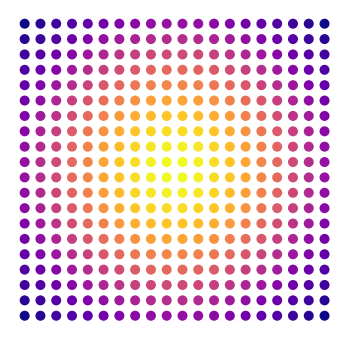

In [4]:
plt = reduction.plot_2d_manifold(x, 
                                 y, 
                                 color=z, 
                                 clean=True, 
                                 s=100, 
                                 color_map=colormap, 
                                 figure_size=(6,6))
if save_figures: plt.savefig('../figures/Supplement-2D-data.png', dpi=300, bbox_inches='tight')

<a id=2D-data-perplexity></a>
### Test perplexity

[Go to the top](#top-page)

('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)
('WARNING: casting training data as', <class 'float'>)


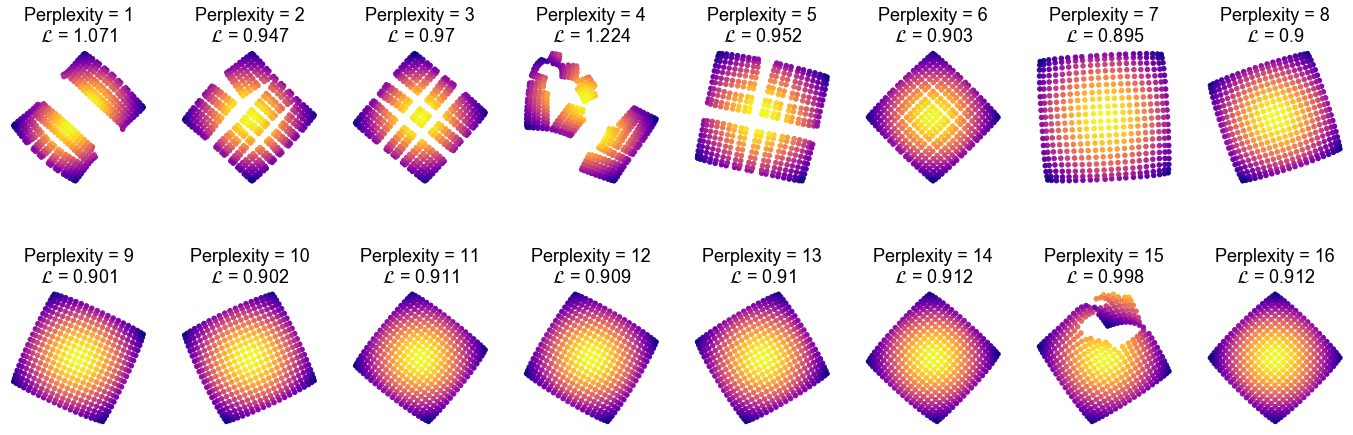

In [20]:
perplexities = [i for i in range(1,9)]

fig = plt.figure(figsize=(len(perplexities)*3, 7))
fig.tight_layout(pad=-30)
widths = [1 for i in perplexities]
heights = [1, 0.4, 1]
spec = fig.add_gridspec(ncols=len(perplexities), nrows=3, width_ratios=widths, height_ratios=heights)

x_range = np.array([i for i in range(0,len(perplexities))])

for i, perplexity in enumerate(perplexities):
    
    ax = fig.add_subplot(spec[0,i])

    X_TSNE = manifold.TSNE(n_components=2, perplexity=perplexity, init="random", random_state=random_seed).fit_transform(data)

    variance_data = analysis.compute_normalized_variance(X_TSNE, 
                                                         z, 
                                                         depvar_names=['var'],
                                                         bandwidth_values=bandwidth_values)

    cost = analysis.cost_function_normalized_variance_derivative(variance_data, 
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm, 
                                                                 integrate_to_peak=False)

    ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=z.ravel(), s=20, cmap=colormap)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.title('Perplexity = ' + str(perplexity) + '\n$\mathcal{L}$ = ' + str(round(cost,3)), fontsize=18)

perplexities = [i for i in range(9,17)]
    
x_range = np.array([i for i in range(0,len(perplexities))])

for i, perplexity in enumerate(perplexities):
    
    ax = fig.add_subplot(spec[2,i])

    X_TSNE = manifold.TSNE(n_components=2, perplexity=perplexity, init="random", random_state=random_seed).fit_transform(data)

    variance_data = analysis.compute_normalized_variance(X_TSNE, 
                                                         z, 
                                                         depvar_names=['var'],
                                                         bandwidth_values=bandwidth_values)

    cost = analysis.cost_function_normalized_variance_derivative(variance_data, 
                                                                 penalty_function=penalty,
                                                                 power=power,
                                                                 norm=norm, 
                                                                 integrate_to_peak=False)

    ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=z.ravel(), s=20, cmap=colormap)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.title('Perplexity = ' + str(perplexity) + '\n$\mathcal{L}$ = ' + str(round(cost,3)), fontsize=18)

if save_figures: plt.savefig('../figures/projections-varying-perplexity.svg', dpi=200, bbox_inches='tight')

In [6]:
X_TSNE_15 = manifold.TSNE(n_components=2, perplexity=15, init="random", random_state=random_seed).fit_transform(data)
X_TSNE_7 = manifold.TSNE(n_components=2, perplexity=7, init="random", random_state=random_seed).fit_transform(data)

In [7]:
tic = time.perf_counter()

variance_data_7 = analysis.compute_normalized_variance(X_TSNE_7,
                                                       z,
                                                       depvar_names=['var'],
                                                       bandwidth_values=bandwidth_values)

derivative_7, sigmas_7, _ = analysis.normalized_variance_derivative(variance_data_7)

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.0 minutes.
----------------------------------------


In [8]:
cost_perplexity_7 = analysis.cost_function_normalized_variance_derivative(variance_data_7,
                                                             penalty_function=penalty,
                                                             power=power,
                                                             norm=norm,
                                                             integrate_to_peak=False)

print(cost_perplexity_7)

0.895256135089244


In [9]:
tic = time.perf_counter()

variance_data_15 = analysis.compute_normalized_variance(X_TSNE_15,
                                                       z,
                                                       depvar_names=['var'],
                                                       bandwidth_values=bandwidth_values)

derivative_15, sigmas_15, _ = analysis.normalized_variance_derivative(variance_data_15)

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

('WARNING: casting training data as', <class 'float'>)
	Time it took: 0.0 minutes.
----------------------------------------


In [10]:
cost_perplexity_15 = analysis.cost_function_normalized_variance_derivative(variance_data_15,
                                                             penalty_function=penalty,
                                                             power=power,
                                                             norm=norm,
                                                             integrate_to_peak=False)

print(cost_perplexity_15)

0.9978331666037249


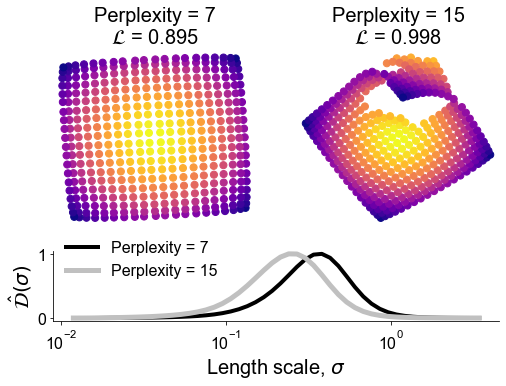

In [19]:
fig = plt.figure(figsize=(8, 5))
widths = [1, 1]
heights = [1, 0.4]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(spec[0,0])
plt.scatter(X_TSNE_7[:,0], X_TSNE_7[:,1], c=z.ravel(), cmap=colormap, s=50)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.title('Perplexity = 7\n$\mathcal{L}$ = ' + str(round(cost_perplexity_7,3)), fontsize=20)

ax = fig.add_subplot(spec[0,1])
scat = plt.scatter(X_TSNE_15[:,0], X_TSNE_15[:,1], c=z.ravel(), cmap=colormap, s=50)
plt.xticks([])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.title('Perplexity = 15\n$\mathcal{L}$ = ' + str(round(cost_perplexity_15,3)), fontsize=20)

ax = fig.add_subplot(spec[1,0:2])
plt.semilogx(sigmas_7[100:150], derivative_7['var'][100:150], color='k', lw=4, label='Perplexity = 7')
plt.semilogx(sigmas_15[100:150], derivative_15['var'][100:150], color='#c0c0c0', lw=5, label='Perplexity = 15')
plt.xlabel('Length scale, $\sigma$', fontsize=20)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=20)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.4,0.4))

if save_figures: plt.savefig('../figures/2D-grid-comparison.svg', dpi=300, bbox_inches='tight')

***